In [ ]:
import os
import shutil
import tempfile

import cv2 as cv
import imageio
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import time
from joblib import Parallel, delayed
from PIL import Image  # noqa
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
from scipy.interpolate import splev, splrep
from scipy.signal import savgol_filter, medfilt
from scipy import ndimage
from itertools import product

import seedir as sd
from ball_detection.dataset import YoloDataset
from ball_detection.utils import cv2pil, pil2cv
from einops import rearrange
from IPython.display import Video

## Methods

In [ ]:
def make_homo(imgs, ref_img, s=0.3, n_jobs=1,FLANN_INDEX_KDTREE=1,MIN_MATCH_COUNT = 10,
              trees=5,k=2,n_ratio=0.7,checks = 50,ransacReprojThreshold = 5.0, nskip=0, w1=1, w2=1):
    """
    TODO: Resizeできるようにする。
    img1 = imgs[0]
    """
    def _make_homo(img1, img2):
        
        ### TODO: はいパラを調整できるようにしたほうがいい　≒　引数で渡せるようにする
        sift = cv.SIFT_create()
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = trees)
        search_params = dict(checks = checks)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        ###
        img1 = cv.resize(img1, (0,0), fx=s, fy=s)
        img2 = cv.resize(img2, (0,0), fx=s, fy=s)

        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None) 
        
        matches = flann.knnMatch(des1,des2,k=k)
        good = []
        for m,n in matches:
            if m.distance < n_ratio*n.distance:
                good.append(m)
                
        assert len(good)>MIN_MATCH_COUNT
        
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, ransacReprojThreshold)
        
        S = [[1,1,s ],[ 1,1, s],[ 1/s, 1/s, 1]]
        return H / S
    
    H = Parallel(n_jobs=n_jobs, prefer='threads')(delayed(_make_homo)(ref_img, img2) for img2 in imgs[::nskip+1])
    H = np.asarray(H)
        
    #Smoothing stuf
    new_H = np.zeros((len(imgs), 3, 3))
    for i, j in product(range(3), range(3)):    
        x = range(len(imgs))[::nskip+1]
        y = H[:, i, j]
        assert len(x) == len(y), (len(x), len(y))
        
        if w1 > 1:
            y = medfilt(y, w1)
        if w2 > 1:
            y = savgol_filter(y, w2, 1)

        spl = splrep(x, y)
        x2 = np.linspace(0, len(imgs), len(imgs), endpoint=False)
        y2 = splev(x2, spl)
        new_H[:, i, j] = y2

    return new_H

#PCAで画像を選択してStitch
def make_pano(H, imgs):
    X = H.copy()
    X = rearrange(X, 'N w h -> N (w h)')

    pca = PCA(n_components=1)
    X = pca.fit_transform(X)

    idxs = X.flatten().argsort() # list of indexes sorted by 1st PC
    selected_idxs = np.hstack([idxs[0:-1:400], idxs[-1]])
    
    stitcher = cv.Stitcher_create()
    stitched = stitcher.stitch([imgs[i] for i in selected_idxs])[1]
    
    return cv2pil(stitched)

#ランダムで画像を選択してStitch
def make_pano2(imgs, n):
    selected_idxs = np.random.choice(range(len(imgs)), n)
    
    stitcher = cv.Stitcher_create()
    stitched = stitcher.stitch([imgs[i] for i in selected_idxs])[1]
    
    return cv2pil(stitched)

def make_video(images: list, fps: int, outpath: str = 'video.mp4'):
    """The main def for creating a temporary video out of the 
    PIL Image list passed, according to the FPS passed
    Parameters
    ----------
    image_list : list
        A list of PIL Images in sequential order you want the video to be generated
    fps : int
        The FPS of the video
    """
    with tempfile.TemporaryDirectory() as dirpath:  # Example: '/tmp/tmpacxadh7t'
        n_imgs = len(kick_dataset)
        filenames = [os.path.join(dirpath, f"{i:06d}.png") for i in range(n_imgs)]
        
        par_func = lambda i, f: i.save(f)
        Parallel(n_jobs=-1)(delayed(par_func)(img, fname) for img, fname in tqdm(zip(images, filenames), total=n_imgs))
            
#         file = os.path.join(dirpath, '%6d.png')
#         os.system(f'ffmpeg -i f"{file}" -c:v libx264 -vf "fps={fps}" {outpath}')
        writer = imageio.get_writer(outpath, fps=fps)
                     
        for fname in tqdm(filenames, total=n_imgs):
            writer.append_data(imageio.imread(fname))
        writer.close()

    print(f"Find your images and video at {outpath}")

def calc_error(kick_dataset,Hp):
    annot_df = pd.concat([annot for im, annot in kick_dataset])
    W, H = kick_dataset[0][0].size

    _KP1 = annot_df[annot_df.label==1].drop(['label', 'width', 'height'], axis=1).values * np.asarray([W, H])
    _KP2 = annot_df[annot_df.label==2].drop(['label', 'width', 'height'], axis=1).values * np.asarray([W, H])
    _KP3 = annot_df[annot_df.label==3].drop(['label', 'width', 'height'], axis=1).values * np.asarray([W, H])

    KP1 = np.hstack((_KP1, np.ones((len(Hp), 1)))) 
    KP2 = np.hstack((_KP2, np.ones((len(Hp), 1))))
    KP3 = np.hstack((_KP3, np.ones((len(Hp), 1))))

    KP1 = rearrange(KP1, 'N dim -> N dim 1')
    KP2 = rearrange(KP2, 'N dim -> N dim 1')
    KP3 = rearrange(KP3, 'N dim -> N dim 1')

    FP1 = (Hp @ KP1 / (Hp @ KP1)[:, 2:, :])[:, :2].squeeze()
    FP2 = (Hp @ KP2 / (Hp @ KP2)[:, 2:, :])[:, :2].squeeze()
    FP3 = (Hp @ KP3 / (Hp @ KP3)[:, 2:, :])[:, :2].squeeze()

    FP = np.mean([FP1,FP2,FP3],axis=0)
    l1 = np.linalg.norm(np.diff(_KP1, axis=0), axis=1)
    l2 = np.linalg.norm(np.diff(FP,axis=0), axis=1)
    
    return l1.mean(),l2.mean()

In [ ]:
kick_dir = '/data/datasets/sample_kick'
kick_dataset = YoloDataset(kick_dir)

imgs = [pil2cv(im) for im, annot in tqdm(kick_dataset)]

  0%|          | 0/1172 [00:00<?, ?it/s]

In [ ]:
import cv2
import numpy as np
cap = cv2.VideoCapture("vtest.avi")

frame1 = imgs[0]
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
flows = []
for frame2 in tqdm(imgs[1:]):
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    flows.append(flow)
#     mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
#     hsv[...,0] = ang*180/np.pi/2
#     hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
#     rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    


  0%|          | 0/1171 [00:00<?, ?it/s]

In [ ]:
np.median(x), np.mean(x)

(0.08005597, -1.5988973)

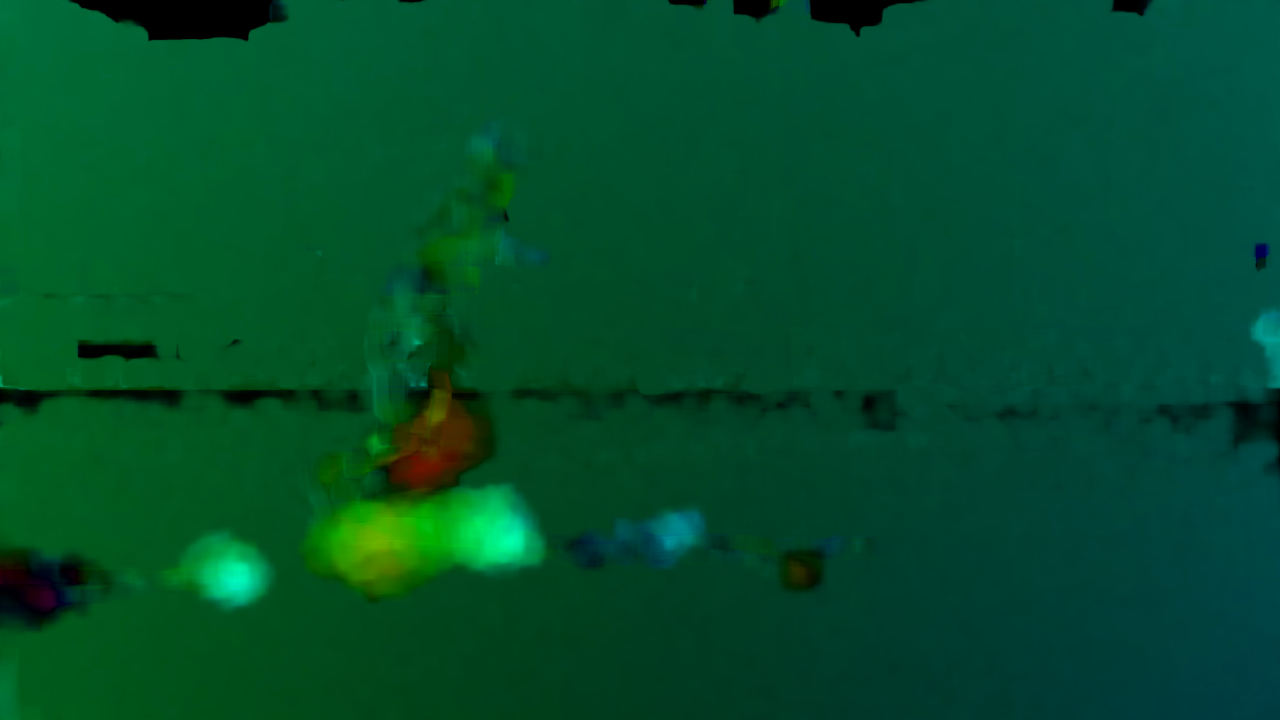

In [ ]:
cv2pil(rgbs[400])

  0%|          | 0/1171 [00:00<?, ?it/s]

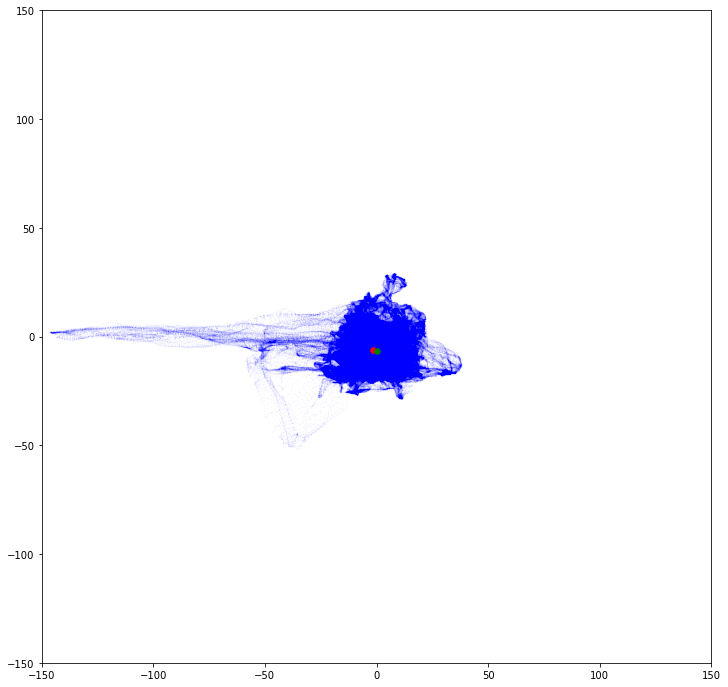

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from celluloid import Camera

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
camera = Camera(fig)

for flow in tqdm(flows):
    x = flow[:, :, 0].flatten()
    y = flow[:, :, 1].flatten()
    plt.scatter(x, y, s=0.1, alpha=0.05, color='blue')
    plt.scatter(x.mean(), y.mean(), s=30, alpha=1, color='red')
    plt.scatter(np.median(x), np.median(y), s=30, alpha=1, color='green')
    plt.xlim(-150, 150)
    plt.ylim(-150,150)
    camera.snap()
    
    
animation = camera.animate()
animation.save('animation.mp4', fps=50)
Video('animation.mp4')